In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [5]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/not_hand/*.png")

In [6]:
len(hand_files)

3244

In [7]:
len(not_hand_files)

3244

# Camera Image

## Preprocessing

In [8]:
from vision_control.camera import *

In [12]:
img = CameraImage(file_path=hand_files[50])

In [13]:
img.preprocess()

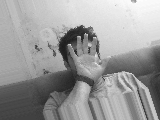

In [14]:
img

## Building the dataset

In [9]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True,full = False) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True,full = False) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|████████████| 3244/3244 [00:06<00:00, 536.11it/s]


In [10]:
images = CameraImages(camera_images=all_img)

In [17]:
X = images.build_X()

100%|██████████████████████████████████████| 6488/6488 [03:15<00:00, 33.15it/s]


In [18]:
X.shape

(6488, 19200)

In [11]:
y = images.build_y()

In [12]:
y.shape

(6488, 1)

# Train a simple model

In [13]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


## Creating the MLP

In [117]:
model = Sequential()
model.add(Dense(512,input_dim = X.shape[1],activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
optimizer = Adam(lr=0.002)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
from sklearn.model_selection import train_test_split

In [100]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [118]:
model.fit(X_train,y_train,epochs=50,verbose = 2,batch_size=32,shuffle=True,validation_data=(X_test,y_test))

Train on 4866 samples, validate on 1622 samples
Epoch 1/50
49s - loss: 0.9721 - acc: 0.5099 - val_loss: 0.6898 - val_acc: 0.6178
Epoch 2/50
45s - loss: 0.6963 - acc: 0.5306 - val_loss: 0.6914 - val_acc: 0.4994
Epoch 3/50
44s - loss: 0.6977 - acc: 0.5308 - val_loss: 0.6886 - val_acc: 0.5247
Epoch 4/50
45s - loss: 0.6918 - acc: 0.5485 - val_loss: 0.6890 - val_acc: 0.5123
Epoch 5/50
47s - loss: 0.6879 - acc: 0.5454 - val_loss: 0.6827 - val_acc: 0.5197
Epoch 6/50
48s - loss: 0.6763 - acc: 0.5853 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 7/50
48s - loss: 0.6762 - acc: 0.5824 - val_loss: 0.6800 - val_acc: 0.5216
Epoch 8/50
48s - loss: 0.6708 - acc: 0.6021 - val_loss: 0.6828 - val_acc: 0.5456
Epoch 9/50
46s - loss: 0.6702 - acc: 0.5892 - val_loss: 0.6846 - val_acc: 0.5216
Epoch 10/50
44s - loss: 0.6664 - acc: 0.6083 - val_loss: 0.6733 - val_acc: 0.5438
Epoch 11/50
45s - loss: 0.6635 - acc: 0.6147 - val_loss: 0.6962 - val_acc: 0.5000
Epoch 12/50
52s - loss: 0.6531 - acc: 0.6235 - val_loss: 0.

## Live test

In [183]:
test = CameraImage(capture = True)

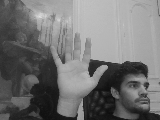

In [184]:
test

In [185]:
test.predict(model,full = True,flatten = False)

0.69981021

In [127]:
selection = np.random.randint(1,1000,10)

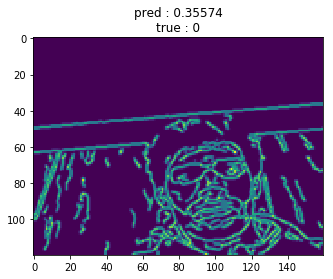

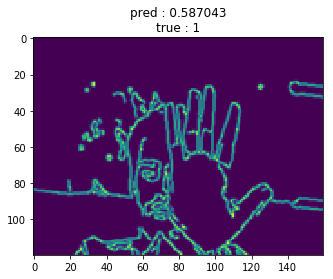

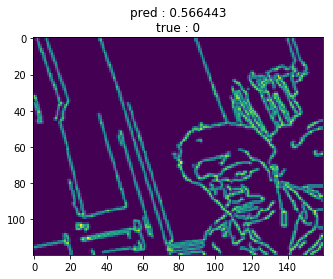

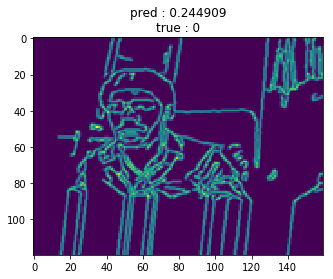

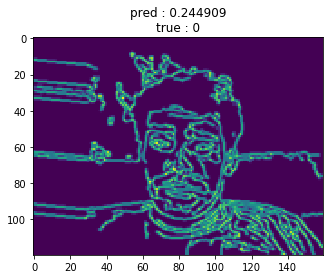

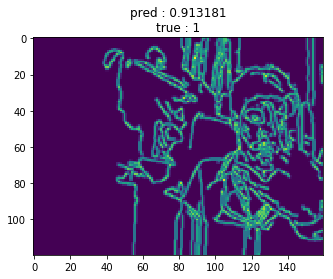

In [135]:
for i in selection:
    x = X_test[i]
    y = y_test[i][0]
    
    
    pred = model.predict(np.expand_dims(x,axis = 0))[0][0]
    plt.imshow(x.reshape((120,160)))
    plt.title("pred : {0:3g}\ntrue : {1}".format(pred,y))
    plt.show()

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

## Saving the model

In [170]:
model.save("C:/git/computer-vision-control/models/model_cnn.h5")

In [171]:
with open("C:/git/computer-vision-control/models/model_cnn.json", "w") as json_file:
    json_file.write(model.to_json())

## Test reloading the model

In [2]:
%%time
from keras.models import model_from_json

Wall time: 0 ns


In [10]:
model = model_from_json(open("C:/git/computer-vision-control/models/model_mlp.json","r").read())
model.load_weights("C:/git/computer-vision-control/models/model_mlp.h5")

# Train a more complex model : CNN

## Building a dataset not flattened

In [15]:
X = images.build_X(flatten=False)
X.shape

100%|██████████████████████████████████████| 6488/6488 [03:16<00:00, 32.94it/s]


(6488, 120, 160, 1)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

## Creating the model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(120,160,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,verbose = 1)

Train on 4866 samples, validate on 1622 samples
Epoch 1/10
4866/4866 [==============================] - ETA: 421s - loss: 0.6948 - acc: 0.500 - ETA: 338s - loss: 0.8681 - acc: 0.546 - ETA: 307s - loss: 1.1312 - acc: 0.541 - ETA: 292s - loss: 1.1176 - acc: 0.523 - ETA: 283s - loss: 1.0314 - acc: 0.537 - ETA: 275s - loss: 0.9696 - acc: 0.541 - ETA: 269s - loss: 0.9325 - acc: 0.526 - ETA: 264s - loss: 0.9044 - acc: 0.511 - ETA: 260s - loss: 0.8813 - acc: 0.513 - ETA: 257s - loss: 0.8626 - acc: 0.521 - ETA: 254s - loss: 0.8475 - acc: 0.508 - ETA: 251s - loss: 0.8346 - acc: 0.518 - ETA: 248s - loss: 0.8236 - acc: 0.519 - ETA: 245s - loss: 0.8142 - acc: 0.524 - ETA: 242s - loss: 0.8061 - acc: 0.522 - ETA: 240s - loss: 0.7991 - acc: 0.523 - ETA: 238s - loss: 0.7928 - acc: 0.523 - ETA: 235s - loss: 0.7872 - acc: 0.520 - ETA: 233s - loss: 0.7821 - acc: 0.524 - ETA: 231s - loss: 0.7774 - acc: 0.525 - ETA: 229s - loss: 0.7733 - acc: 0.526 - ETA: 227s - loss: 0.7692 - acc: 0.534 - ETA: 225s - loss

In [169]:
test.predict(model,flatten = False)

0.51472992

# Image Data Generator fit

https://keras.io/preprocessing/image/<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Image Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
#         rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [38]:
hand_generator = train_datagen.flow(X[:367],y[:367],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/hand/')  # since we use binary_crossentropy loss, we need binary labels

not_hand_generator = train_datagen.flow(X[367:],y[367:],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/not_hand/')  # since we use binary_crossentropy loss, we need binary labels

In [40]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 

In [41]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in not_hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 

# Building on top of a pre trained model

In [228]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

In [233]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False,input_shape=(120,160,3))

In [234]:
model_vgg16_conv.output_shape

(None, 3, 5, 512)

In [235]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg16_conv.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [244]:
test_x = np.repeat(X[0:1],3,axis = 3)

In [248]:
X_train = np.repeat(X_train,3,axis = 3)

In [249]:
X_test = np.repeat(X_test,3,axis = 3)

In [259]:
model_vgg16_conv.predict(X_train[:100],verbose=2)

 64/100 [==================>...........] - ETA: 20 - ETA: 11s

KeyboardInterrupt: 

In [257]:
X_train_transformed = model_vgg16_conv.predict(X_train,batch_size = )

KeyboardInterrupt: 

In [ ]:
X_test_transformed